In [1]:
import abc
import typing

import tqdm
import numpy
import torch
import pandas
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 256
VAL_SIZE = 5000
TRAIN_SIZE = 45000

RANDOM_STATE = 42
GENERATOR = torch.manual_seed(RANDOM_STATE)

N_EPOCHS = 25

# Download dataset with Pytorch



## Load the data

In [2]:
def image_to_vector(x: torch.Tensor) -> torch.Tensor:
    return torch.cat([
        x.flatten(), # Stretch image into row [32, 32, 3] -> [3072]
        torch.tensor([ 1. ]) # Add constant [3072] -> [3073]
    ])

In [3]:
def test_image_to_vector():
    input = torch.tensor([ [ 1, 2 ], [ 4, 3 ] ])
    expected = torch.tensor([ 1, 2, 4, 3, 1 ])
    actual = image_to_vector(input)
    assert all(actual == expected)

In [4]:
mean = numpy.array([ 0.5, 0.5, 0.5 ])
std = numpy.array([ 0.5, 0.5, 0.5 ])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), # Transform to tensor and normalize
    torchvision.transforms.Normalize(mean, std), # Standartization
    torchvision.transforms.Lambda(image_to_vector) # Stretch
])

# Download a CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    'cifar-10',
    train = True,
    download = True,
    transform = transforms
)

print(train_dataset)

100%|██████████| 170498071/170498071 [00:02<00:00, 70890147.76it/s]


Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar-10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.5 0.5 0.5])
               Lambda()
           )


In [5]:
classes = train_dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Split dataset & define dataloaders

In [6]:
train_sizes = [ TRAIN_SIZE, VAL_SIZE, len(train_dataset) - TRAIN_SIZE - VAL_SIZE ]
train_ds, val_ds, _ = torch.utils.data.random_split(train_dataset, train_sizes, GENERATOR)

assert len(train_ds) == TRAIN_SIZE
assert len(val_ds) == VAL_SIZE

print('Train: {}'.format(len(train_ds)))
print('Validation: {}'.format(len(val_ds)))

Train: 45000
Validation: 5000


In [7]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, generator = GENERATOR)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, generator = GENERATOR)

torch.Size([256, 3073]) torch.Size([256])
tensor(6)


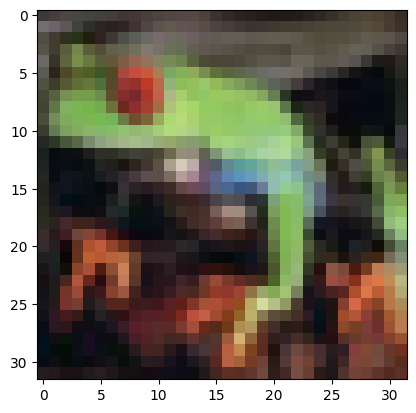

In [8]:
denormalize = torchvision.transforms.Compose([
    torchvision.transforms.Normalize([ 0., 0., 0. ], 1 / std),
    torchvision.transforms.Normalize(-mean, [ 1., 1., 1. ])
])

for images, class_nums in train_loader:
    assert images.dim() == 2
    assert images.shape[0] == BATCH_SIZE
    assert images.shape[1] == 32 * 32 * 3 + 1

    assert class_nums.dim() == 1
    assert class_nums.shape[0] == BATCH_SIZE

    print(images.shape, class_nums.shape)
    plt.imshow(denormalize(images[0][:-1].reshape(3, 32, 32)).permute(1, 2, 0))
    print(class_nums[0])
    break

# Implement LinearClassifier class for CIFAR10

## Losses

In [9]:
class BaseLoss(abc.ABC):
    """Базовый класс лосса"""

    @abc.abstractmethod
    def calc_loss(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> float:
        """
        Функция для вычисления значения лосса
        :param X: torch.Tensor размера (n_objects, n_features) с объектами датасета
        :param y: torch.Tensor размера (n_objects) с правильными ответами
        :param w: torch.Tensor размера (n_features, n_classes) с весами линейной регрессии
        :return: число - значение функции потерь
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        """
        Функция для вычисления градиента лосса по весам w
        :param X: torch.Tensor размера (n_objects, n_features) с объектами датасета
        :param y: torch.Tensor размера (n_objects) с правильными ответами
        :param w: torch.Tensor размера (n_features, n_classes) с весами линейной регрессии
        :return: torch.Tensor размера (n_features, n_classes) - градиент функции потерь по весам w
        """
        raise NotImplementedError

### SVM Loss

#### Basic

In [10]:
class SVMLoss(BaseLoss):
    def calc_loss(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> float:
        loss = 0
        n_objects = X.shape[0]
        scores = torch.mm(X, w)
        for i in range(n_objects):
            target = int(y[i])
            losses = scores[i] - scores[i][target] + 1
            margins = torch.maximum(torch.tensor(0), losses)
            loss += torch.sum(margins) - margins[target]
        return float(loss) / n_objects

    def calc_grad(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        n_objects = X.shape[0]
        n_classes = w.shape[1]
        scores = torch.mm(X, w)
        dW = torch.zeros_like(w)
        for i in range(n_objects):
            target = int(y[i])
            above_zero_loss_count = 0
            losses = scores[i] - scores[i][target] + 1
            for j in range(n_classes):
                if j == target or losses[j] <= 0:
                    continue
                above_zero_loss_count += 1
                dW[:, j] += X[i]
            dW[:, target] -= above_zero_loss_count * X[i]
        return dW

In [11]:
def test_svm_loss():
    X = torch.tensor([
        [ 1., 2., 3., 4., 5. ],
        [ 2., 3., 4., 5., 6. ],
        [ 3., 4., 5., 6., 7. ],
        [ 4., 5., 6., 7., 8. ]
    ])
    y = torch.tensor([ 0., 2., 1., 0. ])
    w = torch.tensor([
        [ 0.1, 0.2, 0.3 ],
        [ 0.2, 0.3, 0.4 ],
        [ 0.3, 0.4, 0.5 ],
        [ 0.4, 0.5, 0.6 ],
        [ 0.5, 0.6, 0.7 ]
    ])

    expected_grad = torch.tensor([
        [-10.,   2.,   8.],
        [-14.,   3.,  11.],
        [-18.,   4.,  14.],
        [-22.,   5.,  17.],
        [-26.,   6.,  20.]
    ])

    loss = SVMLoss()
    assert abs(loss.calc_loss(X, y, w) - 5.25) < 1e-5
    assert numpy.allclose(loss.calc_grad(X, y, w), expected_grad)

test_svm_loss()

#### L2 Regularization

In [12]:
class SVML2Loss(SVMLoss):
    def __init__(self, coeff: float = 1.):
        self.coeff = coeff

    def calc_loss(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> float:
        return super().calc_loss(X, y, w) + self.coeff * float(torch.sum(w * w))

    def calc_grad(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        return super().calc_grad(X, y, w) + 2 * self.coeff * w

In [13]:
def test_svm_l2_loss():
    X = torch.tensor([
        [ 1., 2., 3., 4., 5. ],
        [ 2., 3., 4., 5., 6. ],
        [ 3., 4., 5., 6., 7. ],
        [ 4., 5., 6., 7., 8. ]
    ])
    y = torch.tensor([ 0., 2., 1., 0. ])
    w = torch.tensor([
        [ 0.1, 0.2, 0.3 ],
        [ 0.2, 0.3, 0.4 ],
        [ 0.3, 0.4, 0.5 ],
        [ 0.4, 0.5, 0.6 ],
        [ 0.5, 0.6, 0.7 ]
    ])

    expected_grad = torch.tensor([
        [ -9.8,   2.4,   8.6],
        [-13.6,   3.6,  11.8],
        [-17.4,   4.8,  15.0],
        [-21.2,   6.0,  18.2],
        [-25.0,   7.2,  21.4]
    ])

    loss = SVML2Loss()
    assert abs(loss.calc_loss(X, y, w) - 8.05) < 1e-5
    assert numpy.allclose(loss.calc_grad(X, y, w), expected_grad)

test_svm_l2_loss()

### Cross entropy loss

#### Basic

In [14]:
class CrossEntropyLoss(BaseLoss):
    def calc_loss(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> float:
        loss = torch.tensor(0.)
        n_objects = X.shape[0]
        scores = torch.mm(X, w)
        for i in range(n_objects):
            target = int(y[i])
            scores[i] -= torch.max(scores[i])
            exps = torch.exp(scores[i])
            loss -= torch.log(exps[target] / torch.sum(exps))
        return float(loss) / n_objects

    def calc_grad(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        n_objects = X.shape[0]
        n_classes = w.shape[1]
        scores = torch.mm(X, w)
        for i in range(n_objects):
            scores[i] -= torch.max(scores[i])
            exps = torch.exp(scores[i])
            scores[i] = exps / torch.sum(exps)
        scores[torch.arange(n_objects), y.type(torch.int)] -= 1
        return torch.mm(torch.transpose(X, 0, 1), scores) / n_objects

In [15]:
def test_cross_entropy_loss():
    X = torch.tensor([
        [ 1., 2., 3., 4., 5. ],
        [ 2., 3., 4., 5., 6. ],
        [ 3., 4., 5., 6., 7. ],
        [ 4., 5., 6., 7., 8. ]
    ])
    y = torch.tensor([ 0., 2., 1., 0. ])
    w = torch.tensor([
        [ 0.1, 0.2, 0.3 ],
        [ 0.2, 0.3, 0.4 ],
        [ 0.3, 0.4, 0.5 ],
        [ 0.4, 0.5, 0.6 ],
        [ 0.5, 0.6, 0.7 ]
    ])

    torch_loss = torch.nn.CrossEntropyLoss()
    weights = w.clone().requires_grad_(True)
    expected_loss = torch_loss(torch.mm(X, weights), y.type(torch.uint8))
    expected_loss.backward()
    expected_grad = weights.grad

    loss = CrossEntropyLoss()
    assert abs(loss.calc_loss(X, y, w) - expected_loss) < 1e-5
    assert numpy.allclose(loss.calc_grad(X, y, w), expected_grad)

test_cross_entropy_loss()

#### L2 Regularization

In [16]:
class CrossEntropyL2Loss(CrossEntropyLoss):
    def __init__(self, coeff: float = 1.):
        self.coeff = coeff

    def calc_loss(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> float:
        return super().calc_loss(X, y, w) + self.coeff * float(torch.sum(w * w))

    def calc_grad(self, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
        return super().calc_grad(X, y, w) + 2 * self.coeff * w

## Linear classifier

In [17]:
class LinearClassifier:
    def __init__(self, labels: typing.List[str], loss: BaseLoss):
        self.loss = loss
        self.n_classes = len(labels)

    def train(self, X: torch.Tensor, y: torch.Tensor, learning_rate: float = 0.001) -> float:
        """
          :param X: torch.Tensor размера (n_objects, n_features) с объектами датасета
          :param y: torch.Tensor размера (n_objects) с правильными ответами
        """
        if not hasattr(self, 'w'):
            # Generate a random weight matrix of small numbers
            self.w = torch.randn(X.shape[1], self.n_classes, generator = GENERATOR) * 0.0001

        # Get the gradient and update weights
        self.w -= learning_rate * self.loss.calc_grad(X, y, self.w)

        # Return the loss
        return self.loss.calc_loss(X, y, self.w)

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
          :param X: torch.Tensor размера (n_objects, n_features) с объектами датасета
        """
        scores = torch.mm(X, self.w)
        return torch.argmax(scores, dim = 1)

# Train model

## Function for accuracy checking

Don't change this code

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

def validate(model, dataloader):
    y_predicted = np.array([])
    y_gtrue = np.array([])
    for images, class_nums in dataloader:
        index = model.predict(images)
        y_predicted = np.append(y_predicted, index.numpy())
        y_gtrue = np.append(y_gtrue, class_nums.numpy())
    return accuracy_score(y_gtrue, y_predicted)

## Train loop
Let's train our model

In [19]:
def train(loss: BaseLoss, learning_rate: typing.Callable, n_epochs: int = 25):
    results = {
        'Loss': [ ],
        'Accuracy': [ ],
        'Max coeff': [ ]
    }
    best_accuracy = 0
    model = LinearClassifier(classes, loss)
    for epoch in tqdm.tqdm(range(n_epochs)):
        lr = learning_rate(epoch)
        for images, class_nums in train_loader:
            loss = model.train(images, class_nums, lr)

        accuracy = validate(model, val_loader)
        if best_accuracy < accuracy:
            best_accuracy = accuracy

        results['Loss'].append(loss)
        results['Accuracy'].append(accuracy)
        results['Max coeff'].append(float(torch.max(model.w)))

    results = pandas.DataFrame(results)
    return model, results, best_accuracy

### SVMLoss

In [20]:
def learning_rate(epoch: int):
    return 0.01 * ((1 / (epoch + 1)) ** 0.01)
results = train(SVMLoss(), learning_rate, N_EPOCHS)
svm_model, svm_results, svm_best_val_accuracy = results
print()
print(f"Best validation accuracy: {svm_best_val_accuracy}")
display(svm_results)

100%|██████████| 25/25 [13:15<00:00, 31.81s/it]


Best validation accuracy: 0.3186


,Loss,Accuracy,Max coeff
0,298.155332,0.2710,21.230179
1,308.077402,0.2494,29.016029
2,206.276465,0.2910,31.251335
3,238.783691,0.2710,33.953632
4,240.760645,0.2818,34.553879
5,228.335820,0.2876,34.946766
6,217.106836,0.2908,35.672493
7,238.553223,0.2752,35.212143
8,216.788945,0.2954,35.495850
9,223.766484,0.2884,34.704288


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(svm_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(svm_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(svm_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(svm_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(svm_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(svm_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(svm_results, *[[['Loss', 'Accuracy'], ['Accuracy', 'Max coeff']]], **{})
chart

### SVMLoss with L2 regularization

In [21]:
def learning_rate(epoch: int):
    return 0.1 * ((1 / (epoch + 1)) ** 1)
results = train(SVML2Loss(0.001), learning_rate, N_EPOCHS)
svm_l2_model, svm_l2_results, svm_l2_best_val_accuracy = results
print()
print(f"Best validation accuracy: {svm_l2_best_val_accuracy}")
display(svm_l2_results)

100%|██████████| 25/25 [13:07<00:00, 31.49s/it]


Best validation accuracy: 0.3266


,Loss,Accuracy,Max coeff
0,4934.379500,0.2528,209.513092
1,2728.316219,0.2824,196.229721
2,2024.562844,0.2980,157.232391
3,1427.748938,0.3150,122.472542
4,1240.200539,0.3198,98.324478
5,1078.305988,0.3164,81.899742
6,975.286777,0.3110,69.508957
7,934.115672,0.3046,58.805756
8,828.100488,0.3206,51.136894
9,792.884383,0.3008,46.137512


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(svm_l2_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(svm_l2_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(svm_l2_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(svm_l2_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(svm_l2_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(svm_l2_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(svm_l2_results, *[[['Loss', 'Accuracy'], ['Accuracy', 'Max coeff']]], **{})
chart

### CrossEntropyLoss

In [22]:
def learning_rate(epoch: int):
    return 0.05 * ((1 / (epoch + 1)) ** 0.75)
results = train(CrossEntropyLoss(), learning_rate, N_EPOCHS)
cross_entropy_model, cross_entropy_results, cross_entropy_best_val_accuracy = results
print()
print(f"Best validation accuracy: {cross_entropy_best_val_accuracy}")
display(cross_entropy_results)

100%|██████████| 25/25 [08:55<00:00, 21.41s/it]


Best validation accuracy: 0.4222


,Loss,Accuracy,Max coeff
0,1.636025,0.3898,0.121242
1,1.624145,0.4086,0.186622
2,1.619573,0.4174,0.228333
3,1.616081,0.4184,0.258362
4,1.613256,0.4210,0.281512
5,1.610890,0.4216,0.300165
6,1.608850,0.4222,0.315665
7,1.607052,0.4206,0.328844
8,1.605436,0.4186,0.340247
9,1.603964,0.4168,0.350254


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cross_entropy_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cross_entropy_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cross_entropy_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cross_entropy_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cross_entropy_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cross_entropy_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(cross_entropy_results, *[[['Loss', 'Accuracy'], ['Accuracy', 'Max coeff']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cross_entropy_results, *['Max coeff', 'Loss', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cross_entropy_results, *['Max coeff', 'Accuracy', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cross_entropy_results, *['Max coeff', 'count()', None], **{})
chart

### CrossEntropyLoss with L2 regularization

In [23]:
def learning_rate(epoch: int):
    return 0.05 * ((1 / (epoch + 1)) ** 0.75)
results = train(CrossEntropyL2Loss(0.005), learning_rate, N_EPOCHS)
cross_entropy_l2_model, cross_entropy_l2_results, cross_entropy_l2_best_val_accuracy = results
print()
print(f"Best validation accuracy: {cross_entropy_l2_best_val_accuracy}")
display(cross_entropy_l2_results)

100%|██████████| 25/25 [09:16<00:00, 22.27s/it]


Best validation accuracy: 0.4222


,Loss,Accuracy,Max coeff
0,1.645842,0.3882,0.115886
1,1.639543,0.4074,0.174230
2,1.639013,0.4166,0.209746
3,1.638684,0.4188,0.234417
4,1.638445,0.4182,0.252886
5,1.638262,0.4214,0.267396
6,1.638110,0.4222,0.279187
7,1.637971,0.4208,0.289011
8,1.637838,0.4200,0.297358
9,1.637704,0.4204,0.304559


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cross_entropy_l2_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cross_entropy_l2_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(cross_entropy_l2_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cross_entropy_l2_results, *['Loss'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cross_entropy_l2_results, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(cross_entropy_l2_results, *['Max coeff'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(cross_entropy_l2_results, *[[['Loss', 'Accuracy'], ['Accuracy', 'Max coeff']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cross_entropy_l2_results, *['Max coeff', 'Loss', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cross_entropy_l2_results, *['Max coeff', 'Accuracy', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(cross_entropy_l2_results, *['Max coeff', 'count()', None], **{})
chart

# Check model on test dataset

You must get accuracy above 0.35


In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, top_k_accuracy_score, classification_report

def test(model, test_loader):
    y_predicted = np.array([])
    y_gtrue = np.array([])
    scores = np.empty((0, 10))
    for images, class_nums in test_loader:
        index = model.predict(images)
        y_predicted = np.append(y_predicted, index.numpy())
        y_gtrue = np.append(y_gtrue, class_nums.numpy())

        batch_scores = torch.mm(images, model.w)
        for i in range(batch_scores.shape[0]):
            batch_scores[i] -= torch.max(batch_scores[i])
            exps = torch.exp(batch_scores[i])
            batch_scores[i] = exps / torch.sum(exps)
        scores = np.concatenate([ scores, batch_scores.numpy() ])

    print('Accuracy: {}'.format(accuracy_score(y_gtrue, y_predicted)))
    print('TOP-2 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 2)))
    print('TOP-3 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 3)))
    print('TOP-4 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 4)))
    print('TOP-5 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 5)))
    print('TOP-6 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 6)))
    print('TOP-7 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 7)))
    print('TOP-8 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 8)))
    print('TOP-9 Accuracy: {}'.format(top_k_accuracy_score(y_gtrue, scores, k = 9)))
    print('AUC-ROC: {}'.format(roc_auc_score(y_gtrue, scores, multi_class = 'ovo')))
    print(classification_report(y_gtrue, y_predicted, target_names = classes, digits = 3))

In [25]:
# Download a CIFAR10 dataset
test_dataset = torchvision.datasets.CIFAR10(
    'cifar-10',
    train = False,
    download = True,
    transform = transforms # Transforms stay the same
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, generator = GENERATOR)

Files already downloaded and verified


## SVMLoss

In [26]:
test(svm_model, test_loader)

Accuracy: 0.2999
TOP-2 Accuracy: 0.4615
TOP-3 Accuracy: 0.5578
TOP-4 Accuracy: 0.6211
TOP-5 Accuracy: 0.6771
TOP-6 Accuracy: 0.7422
TOP-7 Accuracy: 0.8083
TOP-8 Accuracy: 0.8796
TOP-9 Accuracy: 0.9327
AUC-ROC: 0.6942511055555556
              precision    recall  f1-score   support

    airplane      0.327     0.177     0.230      1000
  automobile      0.427     0.207     0.279      1000
        bird      0.169     0.322     0.222      1000
         cat      0.232     0.129     0.166      1000
        deer      0.310     0.135     0.188      1000
         dog      0.313     0.285     0.298      1000
        frog      0.239     0.650     0.349      1000
       horse      0.459     0.297     0.361      1000
        ship      0.431     0.516     0.470      1000
       truck      0.469     0.281     0.351      1000

    accuracy                          0.300     10000
   macro avg      0.338     0.300     0.291     10000
weighted avg      0.338     0.300     0.291     10000



Точность достаточно низкая и на тестовой выборке не достигает даже 30%. По другим метрикам качество модели также невелико, а Top-n-accuracy указывает, что модель ошибается значительно: при ошибке верный класс часто оказывается далеко не самым вероятным (лишь в чуть больше, чем 2/3 слуаев, верный класс оказывается среди 5 с наибольшей предсказанной вероятностью)

## SVMLoss with L2 regularization

In [27]:
test(svm_l2_model, test_loader)

Accuracy: 0.3126
TOP-2 Accuracy: 0.497
TOP-3 Accuracy: 0.623
TOP-4 Accuracy: 0.7206
TOP-5 Accuracy: 0.794
TOP-6 Accuracy: 0.8535
TOP-7 Accuracy: 0.8982
TOP-8 Accuracy: 0.9388
TOP-9 Accuracy: 0.9737
AUC-ROC: 0.7420361777777778
              precision    recall  f1-score   support

    airplane      0.338     0.278     0.305      1000
  automobile      0.336     0.368     0.351      1000
        bird      0.225     0.229     0.227      1000
         cat      0.228     0.209     0.218      1000
        deer      0.246     0.180     0.208      1000
         dog      0.276     0.222     0.246      1000
        frog      0.301     0.503     0.377      1000
       horse      0.365     0.351     0.358      1000
        ship      0.405     0.527     0.458      1000
       truck      0.383     0.259     0.309      1000

    accuracy                          0.313     10000
   macro avg      0.310     0.313     0.306     10000
weighted avg      0.310     0.313     0.306     10000



При применении L2-регуляризации качество модели немного увеличилось: модель верно предсказала класс для 31% объектов, а верный класс был среди 5 наиболее вероятных в почти 80% случаев и среди двух наиболее вероятных для половины объектов. \
Интересно заметить, что максимальное число в матрице весов получилось почти в два раза меньше, чем при отсутствии регуляризации (18 против 34). Это и есть ожидаемый эффект: лосс-функция не допускает переобучение модели - подбор слишком больших весов, которые точно не могут быть правильными в общем случае.

## CrossEntropyLoss

In [28]:
test(cross_entropy_model, test_loader)

Accuracy: 0.4138
TOP-2 Accuracy: 0.5999
TOP-3 Accuracy: 0.7227
TOP-4 Accuracy: 0.8044
TOP-5 Accuracy: 0.8644
TOP-6 Accuracy: 0.9101
TOP-7 Accuracy: 0.9426
TOP-8 Accuracy: 0.966
TOP-9 Accuracy: 0.986
AUC-ROC: 0.8207884222222223
              precision    recall  f1-score   support

    airplane      0.460     0.483     0.471      1000
  automobile      0.452     0.488     0.469      1000
        bird      0.329     0.265     0.294      1000
         cat      0.304     0.286     0.295      1000
        deer      0.372     0.285     0.323      1000
         dog      0.364     0.333     0.348      1000
        frog      0.410     0.520     0.458      1000
       horse      0.466     0.468     0.467      1000
        ship      0.481     0.551     0.514      1000
       truck      0.448     0.459     0.453      1000

    accuracy                          0.414     10000
   macro avg      0.409     0.414     0.409     10000
weighted avg      0.409     0.414     0.409     10000



В сравнении с моделями, использующими SVM Loss, качество значительно увеличилось. Accuracy и recall превысили 41%, а precision и f1-мера - 40%. Верный класс оказывается среди двух наиболее вероятных в 60% случаев, а в 86% - среди 5 наиболее вероятных. Таким образом, логистическая функция потерь гораздо лучше подходит для решения поставленной задачи, чем SVM Loss. \
Интересно, что наблюдается монотонное убывание величины лосса на протяжении всех 25 шагов обучения, чего не наблюдалось при использовании SVM Loss (начиная с некоторого момента значение просто начинало колебаться). Можно предположить, что логистическая функция потерь гораздо лучше подходит для обучения методом градиентного спуска. Тем не менее дальнейшее увеличение количества эпох, скорее всего, не целесообразно и приведет к переобучению - величина наибольшего коэффициента в матрице весов также монотонно увеличивается. \
Также интересно отметить, что обучение модели произошло заметно быстрее. Следовательно, можно утверждать, что во время обучения модель тратит наибольшее время на вычисление лосс-функции и её градиента, что реализовано более эффективно для логистической функции потерь.

## CrossEntropyLoss with L2 regularization

In [29]:
test(cross_entropy_l2_model, test_loader)

Accuracy: 0.4146
TOP-2 Accuracy: 0.6035
TOP-3 Accuracy: 0.722
TOP-4 Accuracy: 0.8007
TOP-5 Accuracy: 0.862
TOP-6 Accuracy: 0.9089
TOP-7 Accuracy: 0.9417
TOP-8 Accuracy: 0.9645
TOP-9 Accuracy: 0.9855
AUC-ROC: 0.820061461111111
              precision    recall  f1-score   support

    airplane      0.468     0.478     0.473      1000
  automobile      0.454     0.489     0.471      1000
        bird      0.324     0.258     0.287      1000
         cat      0.314     0.278     0.295      1000
        deer      0.378     0.281     0.322      1000
         dog      0.372     0.334     0.352      1000
        frog      0.408     0.546     0.467      1000
       horse      0.459     0.468     0.463      1000
        ship      0.471     0.551     0.508      1000
       truck      0.441     0.463     0.452      1000

    accuracy                          0.415     10000
   macro avg      0.409     0.415     0.409     10000
weighted avg      0.409     0.415     0.409     10000



L2-регуляризация логистической функции потерь позволила увеличить точность модели лишь незначительно - на 0.08%. Остальные метрики качества также не претерпели значительных изменений в связи с использованием регуляризации. Тем не менее видно, что наибольший коэффициент в матрице весов уменьшился на 15% - ожидаемый эффект от регуляризации.

# Place for brief conclusion
Модель достаточно простая: обучение происходит относительно быстро, учитывая большой размер тренировочной выборки, а применение - очень лёгкая операция. Тем не менее качество модели невелико (точность лишь немного превышает 41%). Следовательно, реализованная модель не очень хорошо подходит для классификации картинок, так как не учитывает связность пикселей, а рассматривает картинку лишь как набор независимых признаков. \
Выбор лосс-функции сильно влияет на результат: логистическая функция потерь (Cross Entropy Loss) показала значительно более высокое качество, чем SVM Loss (40% против 30%), а обучение модели с использованием логистической функции потерь произошло заметно быстрее. \
Применение L2-регуляризации заметно влияет на модель, которая оптимизирует SVM Loss. Тем не менее значительного повышения качества при использовании логистической функции потерь мне добиться не удалось.

# Ideas for extra work

- Implenment CrossEntropyLoss function ✅
- Implement bias trick ✅
- Add regularization to SVM loss ✅
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data ✅


